In [1]:
import copy
import torch
import warnings
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn.functional as F

from pathlib import Path
from tqdm.auto import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
# from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings('ignore')


/home/sayak/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
set_seed(2024)
seed_worker(2024)

Random seed 2024 has been set.


In [ ]:
OUTPUTS_DIR = 'outputs_gmm'

if not Path.exists(Path(OUTPUTS_DIR)):
    Path.mkdir(Path(OUTPUTS_DIR), exist_ok=True, parents=True)

LOAD_DATA_FROM_FILE = True

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

## PyTorch distributions

[PyTorch](https://pytorch.org/docs/stable/distributions.html) provides several `Distribution` objects. Here, we will explore the `Normal` distribution.

Referred from: Machine Learning II @UMONS

In [ ]:
# We create a normal distribution with mean 0 and standard deviation 1.
dist = D.Normal(0, 1)
print(f'Mean: {dist.loc}, standard deviation: {dist.scale}')

fig, axis = plt.subplots()
x = torch.linspace(-5, 5, 100)
# We plot the probability density function (PDF) using the `log_prob` method.
axis.plot(x, dist.log_prob(x).exp(), label='PDF')
# We plot the cumulative density function (CDF) using the `cdf` method.
axis.plot(x, dist.cdf(x), label='CDF')
# We plot a histogram of 1000 samples from the distribution.
axis.hist(dist.sample((1000,)), density=True, alpha=0.5, label='Samples')
axis.legend()
plt.show()

While PyTorch `Tensor` objects have a single `.shape`, `Distribution` objects have two shape attributes that are semantically different:
- `event_shape`: The shape of a single event from the distribution.
- `batch_shape`: The shape of a single sample from one or more distribution of the same family. As an example, we can’t have a batch of a normal and Gamma distribution together, but we can have a batch of more than one normal distributions with different means and standard deviations.

Additionally, a `sample_shape` argument can be given when sampling from `Distribution` objects.

In [ ]:
# We create 3 normal distributions with means -2, 0 and 2, and standard deviation 1.
dist = D.Normal(torch.tensor([-2., 0., 2.]), torch.ones(3))
# By default, `Normal` distributions have an empty `event_shape` because they are univariate.
assert dist.batch_shape == (3,) and dist.event_shape == ()
# The shape of a sample is `sample_shape + batch_shape + event_shape`.
sample_shape = (2,)
assert dist.sample(sample_shape).shape == (2, 3)
# The shape returned by `log_prob` is `sample_shape + batch_shape`.
assert dist.log_prob(torch.zeros(3)).shape == (3,)

To represent multivariate normal distributions with a diagonal covariance, we can use the `Independent` class.

In [ ]:
dist = D.Normal(torch.tensor([-2., 0., 2.]), torch.ones(3))
# The last dimension of the `batch_shape` is reinterpreted as the `event_shape`.
dist = D.Independent(dist, 1)
assert dist.batch_shape == () and dist.event_shape == (3,)
# Samples keep the same dimension than before.
sample_shape = (2,)
assert dist.sample(sample_shape).shape == (2, 3)
# The shape returned by `log_prob` is different because we compute the log PDF of a single multivariate distribution.
assert dist.log_prob(torch.zeros(3)).shape == ()

In [ ]:
# TODO: Create a `Normal` distribution with a `batch_shape` of `(4, 5)` and an `event_shape` of `(3,)`.
# Fix the means and standard deviations at 0 and 1.
# Then, sample from this distribution with a `sample_shape` of `(2,)`.
# What is the shape of the sampled event?
dist = D.Normal(torch.zeros(4, 5, 3), torch.ones(4, 5, 3))
dist = D.Independent(dist, 1)
assert dist.batch_shape == (4, 5) and dist.event_shape == (3,)
assert dist.sample((2,)).shape == (2, 4, 5, 3)

## Gaussian Mixture Class

In [6]:
class GaussianMixture:
  
  def __init__(self, mus, covs, weights, device='cuda'):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.a = covs
    self.device = device
    self.precs = [torch.from_numpy(np.linalg.inv((cov * torch.eye(2).cuda()).cpu().numpy())).to(cov.device) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(D.Independent(D.Normal(mus[i], covs[i]), 1))
    self.dim = len(mus[0])

  def compute_mean(self):

    mu_bar = 0.0
    for weight, mu in zip(self.norm_weights, self.mus):
      mu_bar += weight * mu

    return mu_bar
  
  def compute_variance(self):

    mu_bar = self.compute_mean()
    var = None
    for weight, mu, cov in zip(self.norm_weights, self.mus, self.covs):

      assert cov[0] == cov[1]

      covmat = cov[0]**2 * torch.eye(2).to(cov.device)

      temp = weight * (covmat + torch.mm((mu - mu_bar).unsqueeze(0).T, (mu - mu_bar).unsqueeze(0))) 
      var = temp if var is None else var + temp

    return var

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov.cpu().numpy()))
    self.RVs.append(D.Independent(D.Normal(mu, cov), 1))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.log_prob(x).exp()
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    isnumpy = False
    if type(x) is np.ndarray:
      isnumpy = True
      x = torch.from_numpy(x).to(self.mus[0].device)

    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.log_prob(x).exp()
        prob = pdf if prob is None else (prob + pdf)

    if isnumpy:
      prob = prob.cpu().numpy()
      
    return prob

  def score(self, x):
    """
    Compute the score $\nabla_x \log p(x)$ for the given $x$.
    """
    isnumpy = False
    if type(x) is np.ndarray:
      isnumpy = True
      x = torch.from_numpy(x).to(torch.float).to(self.mus[0].device)

    component_pdf = np.array([rv.log_prob(x).exp().cpu().numpy() for rv in self.RVs])
    component_pdf = torch.from_numpy(component_pdf).T
    
    # if isnumpy:
    #   component_pdf = np.array([rv.log_prob(x).exp().cpu().numpy() for rv in self.RVs]).T
    # else:
    #   component_pdf = np.array([rv.log_prob(x).exp() for rv in self.RVs]).T
      
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)
    participance = participance.to(self.mus[0].device)

    scores = torch.zeros_like(x)
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      scores += participance[:, i:i+1] * gradvec

    if isnumpy:
      scores = scores.cpu().numpy()

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.log_prob(x).exp() for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.sample((N,)).cpu().numpy() for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

In [7]:
# Gaussian mixture
mu1 = torch.tensor([2.0, 8.0]).to('cuda')
Cov1 = torch.tensor([1.0, 1.0]).to('cuda')

mu2 = torch.tensor([5.0, 2.0]).to('cuda')
Cov2 = torch.tensor([1.0, 1.0]).to('cuda')

mu3 = torch.tensor([8.0, 8.0]).to('cuda')
Cov3 = torch.tensor([1.0, 1.0]).to('cuda')

gmm = GaussianMixture([mu1, mu2, mu3],[Cov1, Cov2, Cov3], [1.0, 1.0, 1.0])

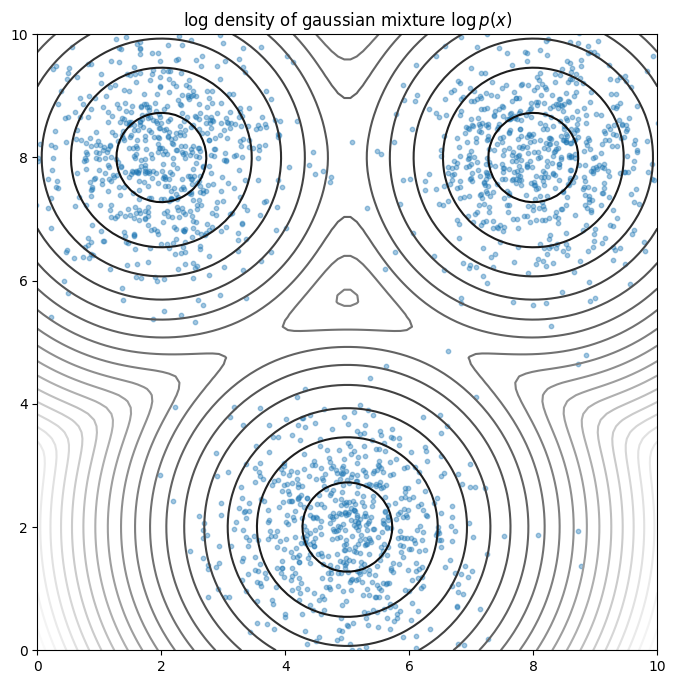

In [8]:
def gmm_pdf_contour_plot(gmm, xlim=None,ylim=None,ticks=100,logprob=False,label=None,**kwargs):
    if xlim is None:
        xlim = plt.xlim()
    if ylim is None:
        ylim = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, ticks), np.linspace(*ylim, ticks))
    pdf = gmm.pdf(np.dstack((xx,yy)))
    if logprob:
        pdf = np.log(pdf)
    plt.contour(xx, yy, pdf, **kwargs,)

# @title Visualize log density
show_samples = True  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm.sample(2000)
plt.figure(figsize=[8, 8])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
gmm_pdf_contour_plot(gmm, cmap="Greys", levels=20, logprob=True)
plt.title("log density of gaussian mixture $\log p(x)$")
# plt.axis("image")
plt.show()

In [12]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, ax = plt.subplots()

# # for idx in range(1):

#     # # the function that I'm going to plot
#     # if idx == 0:
#     #     reward_fn = Reward(target_val1=7, isgaussian=True)
#     # else:
#     #     reward_fn = Reward(target_val1=7, target_val2=3, isgaussian=False)


# def z_func(x, y):
#     h, w = x.shape
#     x_flat = x.reshape(-1)
#     y_flat = y.reshape(-1)
#     x1 = np.column_stack((x_flat, y_flat)).astype('float')
#     # results = np.apply_along_axis(gmm.score, 1, x1)
#     results = gmm.pdf(x1)
#     return results.reshape(h,w)


# x = np.arange(0,10,0.1)
# y = np.arange(10,0,-0.1)
# X,Y = np.meshgrid(x, y) # grid of point
# Z = z_func(X, Y) # evaluation of the function on the grid

# im = ax.imshow(Z, cmap="Blues") # drawing the function

# # adding the colobar on the right
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical')

# ax.set_xticks(ticks=np.arange(0,100,20), labels=np.arange(0,10,2))
# ax.set_yticks(ticks=np.arange(0,100,20), labels=np.arange(10,0,-2))
# ax.axis([0, 100 ,100, 0])
# ax.grid()
# # if idx == 0:
# #     ax[idx].set_title('Gaussian Reward')
# # else:
# #     ax[idx].set_title('Non-Gaussian Reward')

# # plt.show()
# fig.tight_layout()
# # plt.savefig(f'{OUTPUTS_DIR}/rewards.png', dpi=300)

In [13]:
# @title Visualize Score
set_seed(2024)

basedist = D.Independent(D.Normal(torch.tensor([5.0, 6.0]), torch.ones(2)), 1)
gmm_samps_few, _, _ = gmm.sample(300)
gmm_samps_few = np.concatenate([gmm_samps_few, basedist.sample((100,)).cpu().numpy()], axis=0)
scorevecs_few = gmm.score(gmm_samps_few)
# gradvec_list, participance = gmm.score_decompose(gmm_samps_few)

Random seed 2024 has been set.


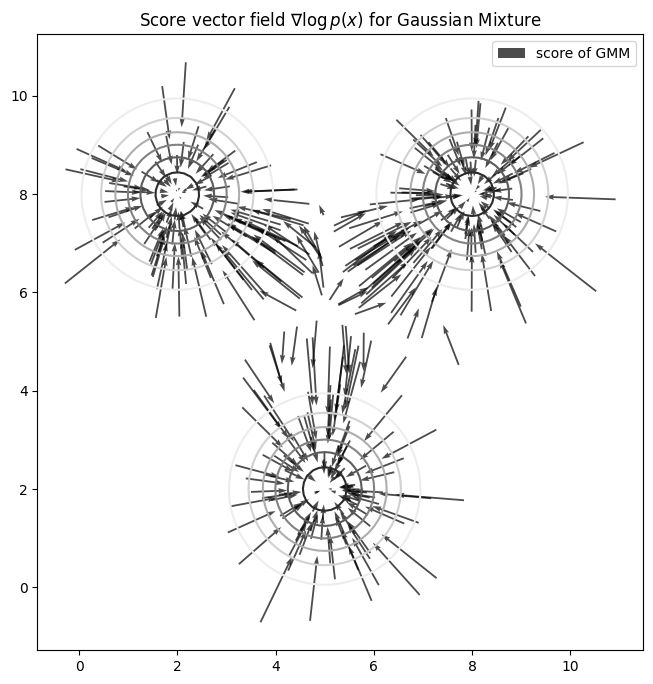

In [14]:
def quiver_plot(pnts, vecs, *args, **kwargs):
  plt.quiver(pnts[:, 0], pnts[:,1], vecs[:, 0], vecs[:, 1], *args, **kwargs)

# @title Score for Gaussian mixture
plt.figure(figsize=[8, 8])
quiver_plot(gmm_samps_few, scorevecs_few,
            color="black", scale=25, alpha=0.7, width=0.003,
            label="score of GMM")
gmm_pdf_contour_plot(gmm, cmap="Greys")
plt.title("Score vector field $\\nabla\log p(x)$ for Gaussian Mixture")
plt.axis("image")
plt.legend()
plt.show()

## Scenarios

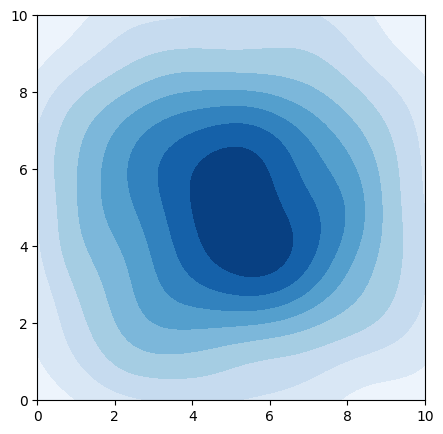

In [112]:
# @title Base Distribution
mu_b = torch.tensor([5.0, 5.0]).to('cuda')
Cov_b = torch.tensor([3.0, 3.0]).to('cuda')

gmm_b = GaussianMixture([mu_b],[Cov_b], [1.0])

# @title Visualize log density
show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples, _, _ = gmm_b.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples[:, 0],
            gmm_samples[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

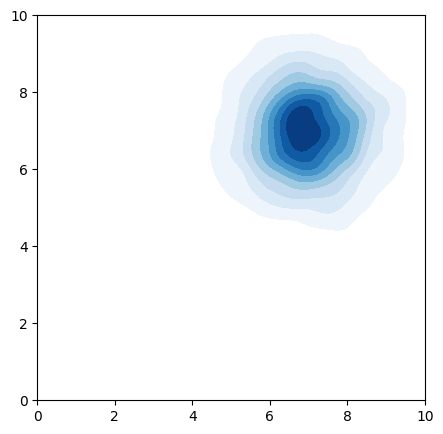

In [113]:
# @title Reward Distribution: Subset of base

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])


show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples_r1, _, _ = gmm_r1.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples_r1[:, 0],
            gmm_samples_r1[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

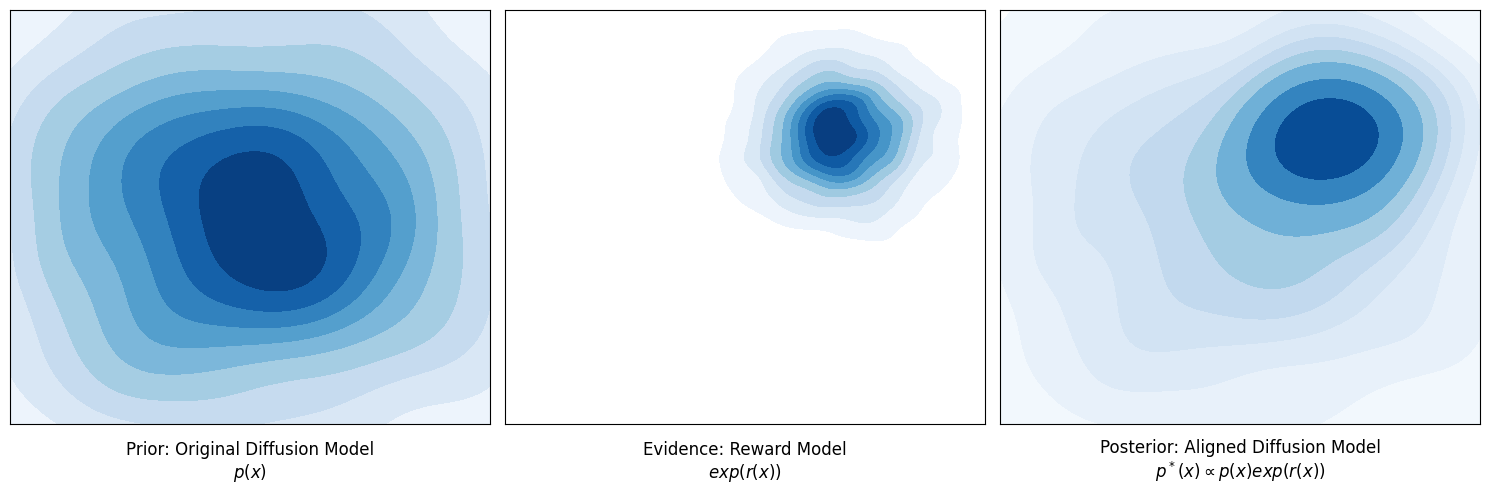

In [115]:
fig, ax = plt.subplots(1,3,figsize=[15, 5])

sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
ax[0].axis([0,10,0,10])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.15)

sns.kdeplot(x=gmm_samples_r1[:,0], y=gmm_samples_r1[:,1], fill=True, ax=ax[1], cmap='Blues')
ax[1].axis([0,10,0,10])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.15)

gmm_samples_overall = np.concatenate([gmm_samples_r1[:800, :], gmm_samples])

sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
ax[2].axis([0,10,0,10])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.15)

plt.tight_layout()
# plt.show()
plt.savefig('subspace.png', dpi=300)

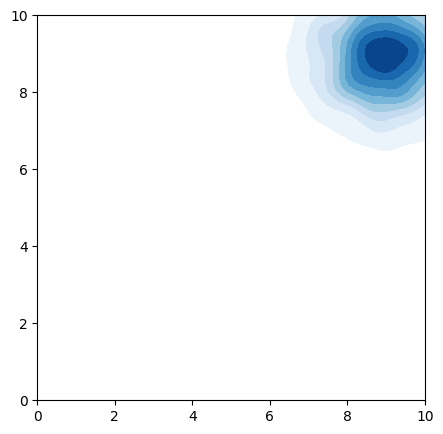

In [116]:
# @title Reward Distribution: Out-of-distristribution

mu_r2 = torch.tensor([9.0, 9.0]).to('cuda')
Cov_r2 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r2 = GaussianMixture([mu_r2],[Cov_r2], [1.0])


show_samples = False  # @param {type:"boolean"}
np.random.seed(42)
gmm_samples_r2, _, _ = gmm_r2.sample(2000)
fig, ax = plt.subplots(figsize=[5, 5])
plt.axis([0,10,0,10])
plt.scatter(gmm_samples_r2[:, 0],
            gmm_samples_r2[:, 1],
            s=10,
            alpha=0.4 if show_samples else 0.0)
# gmm_pdf_contour_plot(gmm_b, cmap="Greys", levels=20, logprob=True)
# plt.title("log density of gaussian mixture $\log p(x)$")
sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax, cmap='Blues')
plt.show()

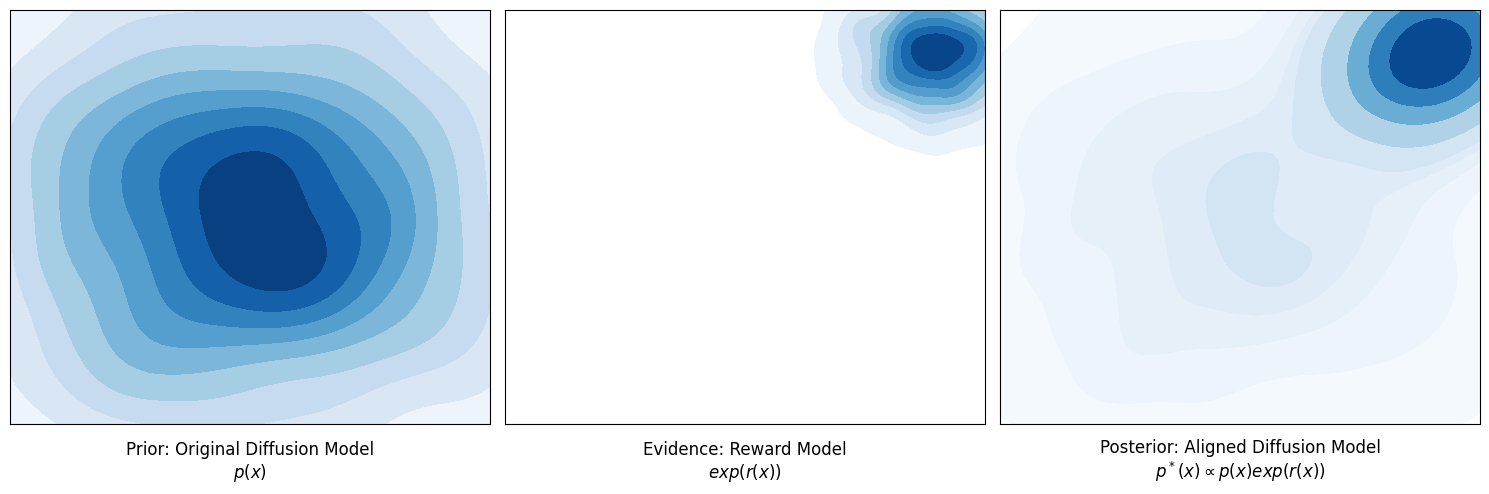

In [118]:
fig, ax = plt.subplots(1,3,figsize=[15, 5])

sns.kdeplot(x=gmm_samples[:,0], y=gmm_samples[:,1], fill=True, ax=ax[0], cmap='Blues')
ax[0].axis([0,10,0,10])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Prior: Original Diffusion Model\n' + r'$p(x)$', y=-0.15)

sns.kdeplot(x=gmm_samples_r2[:,0], y=gmm_samples_r2[:,1], fill=True, ax=ax[1], cmap='Blues')
ax[1].axis([0,10,0,10])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Evidence: Reward Model\n' + r'$exp(r(x))$', y=-0.15)

gmm_samples_overall = np.concatenate([gmm_samples_r2[:2000, :], gmm_samples])

sns.kdeplot(x=gmm_samples_overall[:,0], y=gmm_samples_overall[:,1], fill=True, ax=ax[2], cmap='Blues')
ax[2].axis([0,10,0,10])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Posterior: Aligned Diffusion Model\n' + r'$p^*(x) \propto p(x)exp(r(x))$', y=-0.15)

plt.tight_layout()
# plt.show()
plt.savefig('OOD.png', dpi=300)

## Diffusion Setup

In [79]:
NUM_SAMPLES = 1000
RESAMPLE_NOISE = False # CAUTION: IT WILL OVERWRITE THE NOISE SAMPLES!!!!

if RESAMPLE_NOISE:  
    print('Sampling noise')
    NOISE_SAMPLES = torch.randn(NUM_SAMPLES, 2)
    torch.save(NOISE_SAMPLES, f'{OUTPUTS_DIR}/noise.pt')
else:
    print('Loading noise samples')
    NOISE_SAMPLES = torch.load(f'{OUTPUTS_DIR}/noise.pt')

NOISE_SAMPLES = NOISE_SAMPLES.to(DEVICE)

Loading noise samples


In [80]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size)).to(x.device)
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def forward(self, x: torch.Tensor):
        return self.layer(x)
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0]).to(x.device)
        x2_emb = self.input_mlp2(x[:, 1]).to(x.device)
        t_emb = self.time_mlp(t).to(x.device)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x
    
class Conditional_MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.class_mlp = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer) + len(self.class_mlp.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, y, t):
        # print(f'{x.shape} {y.shape} {t.shape}')
        x1_emb = self.input_mlp1(x[:, 0]).to(x.device)
        x2_emb = self.input_mlp2(x[:, 1]).to(x.device)
        t_emb = self.time_mlp(t).to(x.device)
        y_emb = self.class_mlp(y[:,0]).to(x.device)
        # print(f'{x1_emb.shape} {x2_emb.shape} {t_emb.shape} {y_emb.shape}')
        x = torch.cat((x1_emb, x2_emb, t_emb, y_emb), dim=-1)
        x = self.joint_mlp(x)
        return x
    
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.sqrt_alphas =  self.alphas ** 0.5
        self.sqrt_betas = self.betas ** 0.5
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1).to(x_t.device)
        s2 = s2.reshape(-1, 1).to(x_t.device)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1).to(x_t.device)
        s2 = s2.reshape(-1, 1).to(x_t.device)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(model_output.device)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_original_sample, pred_prev_sample

    def step_wgrad(self, model_output, timestep, sample, grad, scale = 0.5):

        t = timestep

        ## Change
        res = (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())
        model_output = model_output - (scale * self.sqrt_one_minus_alphas_cumprod[t] * grad.float())

        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(model_output.device)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return res, pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1).to(x_start.device)
        s2 = s2.reshape(-1, 1).to(x_start.device)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps
# Define beta schedule
T = 1000
noise_scheduler = NoiseScheduler(
      num_timesteps=T,
      beta_schedule="linear")

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)

    return noise_scheduler.add_noise(x_0, noise, t)

## Experiments (New Setup)

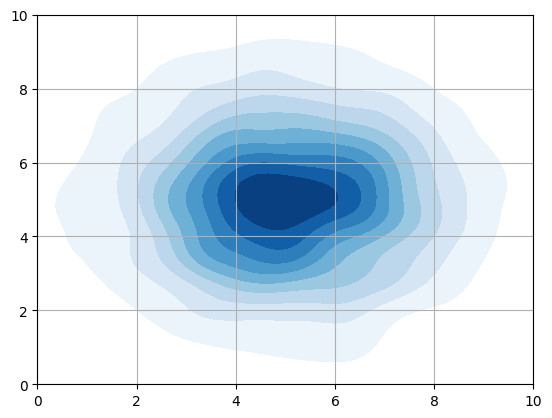

In [101]:
# mu_b = torch.tensor([5.0, 5.0]).to('cuda')
# Cov_b = torch.tensor([1.5, 1.5]).to('cuda')

# gmm_b = GaussianMixture([mu_b],[Cov_b], [1.0])

LOAD_FROM_FILE = True

if LOAD_FROM_FILE:
    dataX = np.load(f'{OUTPUTS_DIR}/dataX_newset.npy')
else:
    cov = np.array([[3, 0], [0, 3]])

    dataX = np.random.multivariate_normal([5.0, 5.0], cov, size=3000)

    np.save(f'{OUTPUTS_DIR}/dataX_newset.npy', dataX)

fig, ax = plt.subplots()

# sns.scatterplot(x=dataX[:,0], y=dataX[:,1], hue=dataY.reshape(-1), ax=ax)

g = sns.kdeplot(x=dataX[:,0], y=dataX[:,1], fill=True, ax = ax, cmap="Blues")

ax.axis([0, 10 ,0, 10])
ax.grid()

plt.show()

In [102]:
data_x = torch.from_numpy(dataX.astype(np.float32))

simpledataset = TensorDataset(data_x) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):

        # print(batch)

        input = batch[0]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input.shape[0],)
        ).long()
        noise = torch.randn(input.shape)
        noisy = noise_scheduler.add_noise(input, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()

torch.save(model, f'{OUTPUTS_DIR}/model_uncond_newset.pt')

Training model...


Epoch 199: 100%|██████████| 200/200 [00:23<00:00,  8.42it/s, loss=0.384]


100%|██████████| 1000/1000 [00:00<00:00, 2554.63it/s]


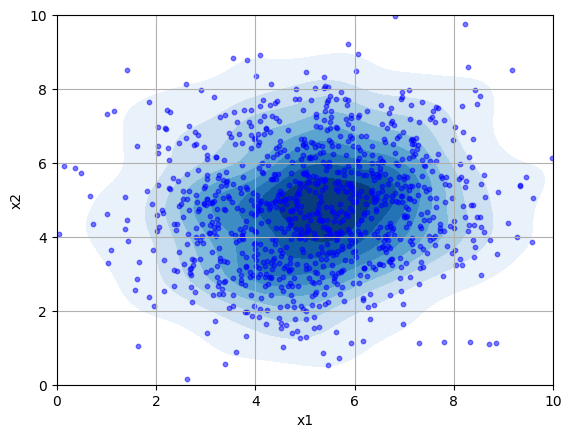

In [103]:
# @title Unconditional sampling

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

curr_sample = copy.deepcopy(NOISE_SAMPLES)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

curr_sample = curr_sample.detach().cpu()

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1514.96it/s]


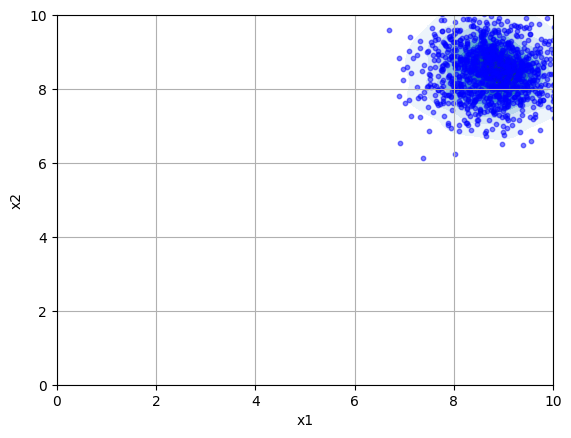

In [110]:
# @title Gradient guidance (Reward Distribution: Subset of base)

mu_r1 = torch.tensor([7.0, 7.0]).to('cuda')
Cov_r1 = torch.tensor([1.0, 1.0]).to('cuda')

gmm_r1 = GaussianMixture([mu_r1],[Cov_r1], [1.0])

model = torch.load(f'{OUTPUTS_DIR}/model_uncond_newset.pt')
model = model.to(DEVICE)
model.eval()

GUIDANCE_SCALE = 0.9
IS_GAUSSIAN_REWARD = True

curr_sample = copy.deepcopy(NOISE_SAMPLES)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    # pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, t[0], residual)
    # print(pred_x0.shape)
    grad = gmm_r1.score(curr_sample)

    res, curr_sample = noise_scheduler.step_wgrad(residual, t[0], curr_sample, grad, scale=GUIDANCE_SCALE)

curr_sample = curr_sample.detach().cpu()

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()

## Training Diffusion Model

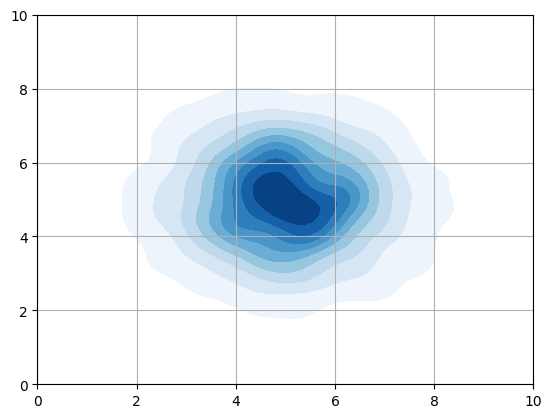

In [83]:
# mu_b = torch.tensor([5.0, 5.0]).to('cuda')
# Cov_b = torch.tensor([1.5, 1.5]).to('cuda')

# gmm_b = GaussianMixture([mu_b],[Cov_b], [1.0])

LOAD_FROM_FILE = False

if LOAD_FROM_FILE:
    dataX = np.load(f'{OUTPUTS_DIR}/dataX.npy')
    dataY = np.load(f'{OUTPUTS_DIR}/dataY.npy')
else:
    cov = np.array([[1.5, 0], [0, 1.5]])

    # x_c1 = np.random.multivariate_normal([5.0, 5.0], cov, size=1000)
    # y_c1 = np.zeros_like(x_c1[:,[1]])

    # x_c2 = np.random.multivariate_normal([5.0, 2.0], cov, size=1000)
    # y_c2 = np.ones_like(x_c2[:,[1]])

    # x_c3 = np.random.multivariate_normal([8.0, 8.0], cov, size=1000)
    # y_c3 = np.ones_like(x_c2[:,[1]]) * 2

    # dataX = np.concatenate([x_c1, x_c2, x_c3], axis=0)
    # dataY = np.concatenate([y_c1, y_c2, y_c3], axis=0)

    dataX = np.random.multivariate_normal([5.0, 5.0], cov, size=2000)

    np.save(f'{OUTPUTS_DIR}/dataX_newset.npy', dataX)
    # np.save(f'{OUTPUTS_DIR}/dataY.npy', dataY)

# data_df = pd.DataFrame({'x1': x_c1[:, 0], 'x2': x_c1[:, 1]})

fig, ax = plt.subplots()

# sns.scatterplot(x=dataX[:,0], y=dataX[:,1], hue=dataY.reshape(-1), ax=ax)

g = sns.kdeplot(x=dataX[:,0], y=dataX[:,1], fill=True, ax = ax, cmap="Blues") # hue=dataY.reshape(-1), 

ax.axis([0, 10 ,0, 10])
ax.grid()

plt.show()

In [ ]:
data_x = torch.from_numpy(dataX.astype(np.float32))
data_y = torch.from_numpy(dataY.astype(np.float32))

simpledataset = TensorDataset(data_x, data_y) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader
model = Conditional_MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):

        input, labels = batch[0], batch[1]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input.shape[0],)
        ).long()
        noise = torch.randn(input.shape)
        noisy = noise_scheduler.add_noise(input, noise, timesteps)
        noise_pred = model(noisy, labels, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()

torch.save(model, f'{OUTPUTS_DIR}/model_cond.pt')

In [ ]:
data_x = torch.from_numpy(dataX.astype(np.float32))
data_y = torch.from_numpy(dataY.astype(np.float32))

simpledataset = TensorDataset(data_x, data_y) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=32) # create your dataloader
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-3,
    )

num_epochs = 200

print("Training model...")

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    for step, batch in enumerate(dataloader):

        input, labels = batch[0], batch[1]

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input.shape[0],)
        ).long()
        noise = torch.randn(input.shape)
        noisy = noise_scheduler.add_noise(input, noise, timesteps)
        noise_pred = model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward(loss)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

progress_bar.close()

torch.save(model, f'{OUTPUTS_DIR}/model_uncond.pt')

In [ ]:
# Load trained model
model = torch.load(f'{OUTPUTS_DIR}/model_cond.pt')
model = model.to(DEVICE)
model.eval()

In [ ]:
sample = copy.deepcopy(NOISE_SAMPLES)
class_label = torch.ones_like(sample[:, [0]])
class_label = class_label.to(sample.device)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
      with torch.no_grad():
          residual = model(sample, class_label, t)

      _, sample = noise_scheduler.step(residual, t[0], sample)

data_df = pd.DataFrame({'x1': sample[:, 0].detach().cpu(), 'x2': sample[:, 1].detach().cpu()})

# torch.save(sample, f'{OUTPUTS_DIR}/uncondGen.pt')

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(sample[:, 0].detach().cpu(), sample[:, 1].detach().cpu(), c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/uncondGen.png',dpi=300)

In [ ]:
# Load trained model
model_uncond = torch.load(f'{OUTPUTS_DIR}/model_uncond.pt')
model_uncond = model_uncond.to(DEVICE)
model_uncond.eval()

In [ ]:
sample = copy.deepcopy(NOISE_SAMPLES)
# class_label = torch.ones_like(sample[:, [0]])
# class_label = class_label.to(sample.device)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
      with torch.no_grad():
          residual = model_uncond(sample, t)

      _, sample = noise_scheduler.step(residual, t[0], sample)

data_df = pd.DataFrame({'x1': sample[:, 0].detach().cpu(), 'x2': sample[:, 1].detach().cpu()})

# torch.save(sample, f'{OUTPUTS_DIR}/uncondGen.pt')

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(sample[:, 0].detach().cpu(), sample[:, 1].detach().cpu(), c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/uncondGen.png',dpi=300)

## Guidance

In [ ]:
# Load trained model
model_cond = torch.load(f'{OUTPUTS_DIR}/model_cond.pt')
model_cond = model_cond.to(DEVICE)
model_cond.eval()

# Load trained model
model_uncond = torch.load(f'{OUTPUTS_DIR}/model_uncond.pt')
model_uncond = model_uncond.to(DEVICE)
model_uncond.eval()

In [ ]:
GUIDANCE_SCALE = 5

sample = copy.deepcopy(NOISE_SAMPLES)

per_class = len(sample)//3

class_label_0 = torch.zeros_like(sample[:per_class, [0]])
class_label_1 = torch.ones_like(sample[per_class:per_class*2, [0]])
class_label_2 = torch.ones_like(sample[per_class*2:, [0]]) * 2

# class_label = torch.ones_like(sample[:, [0]])
class_label = torch.cat([class_label_0, class_label_1, class_label_2])
class_label = class_label.to(sample.device)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
      with torch.no_grad():
          residual_cond = model_cond(sample, class_label, t)
          residual_uncond = model_uncond(sample, t)

          residual = ((1 + GUIDANCE_SCALE) * residual_cond) - (GUIDANCE_SCALE * residual_uncond)

      _, sample = noise_scheduler.step(residual, t[0], sample)

data_df = pd.DataFrame({'x1': sample[:, 0].detach().cpu(), 'x2': sample[:, 1].detach().cpu()})

# torch.save(sample, f'{OUTPUTS_DIR}/uncondGen.pt')

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(sample[:, 0].detach().cpu(), sample[:, 1].detach().cpu(), c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/uncondGen.png',dpi=300)

In [ ]:
# 5,5

# Gaussian mixture
mu1 = torch.tensor([2.0, 8.0]).to('cuda')
Cov1 = torch.tensor([1.0, 1.0]).to('cuda')

mu2 = torch.tensor([5.0, 2.0]).to('cuda')
Cov2 = torch.tensor([1.0, 1.0]).to('cuda')

mu3 = torch.tensor([8.0, 8.0]).to('cuda')
Cov3 = torch.tensor([3.0, 3.0]).to('cuda')

gmm = GaussianMixture([mu1, mu3],[Cov2, Cov3], [1.0, 1.0])

In [ ]:
model = torch.load(f'{OUTPUTS_DIR}/model.pt') #TODO: For debugging DPO
model = model.to(DEVICE)
model.eval()

GUIDANCE_SCALE = 35
IS_GAUSSIAN_REWARD = True

curr_sample = copy.deepcopy(NOISE_SAMPLES)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, NUM_SAMPLES)).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    # pred_x0 = noise_scheduler.reconstruct_x0(curr_sample, t[0], residual)
    # print(pred_x0.shape)
    grad = gmm.score(curr_sample)

    res, curr_sample = noise_scheduler.step_wgrad(residual, t[0], curr_sample, grad, scale=GUIDANCE_SCALE)
    # _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

curr_sample = curr_sample.detach().cpu()

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()

In [ ]:
N = 10
# IS_GAUSSIAN_REWARD = True

sample = copy.deepcopy(NOISE_SAMPLES)
sample = sample

# Load trained model
# model = torch.load(f'{OUTPUTS_DIR}/model_uncond.pt')
model = torch.load(f'outputs/model.pt') #TODO: For debugging DPO
model = model.to(DEVICE)
model.eval()

result = []
result_l = []
result_uncond = []

for idx in tqdm(range(sample.shape[0]), total=sample.shape[0]):

    curr_sample = copy.deepcopy(sample[idx]).unsqueeze(0)
    curr_sample = curr_sample.repeat(N,1)

    timesteps = list(range(len(noise_scheduler)))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, N)).long().to(DEVICE)
        with torch.no_grad():
            residual = model(curr_sample, t)

        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)
        
    reward = gmm.pdf(curr_sample)
    select_ind = torch.max(reward, dim=0)[1]
    result.append(curr_sample[select_ind.item()].unsqueeze(0))

    select_ind_l = torch.min(reward, dim=0)[1]
    result_l.append(curr_sample[select_ind_l.item()].unsqueeze(0))

    result_uncond.append(curr_sample)

result = torch.cat(result, dim=0)
result_l = torch.cat(result_l, dim=0)
result_uncond = torch.cat(result_uncond, dim=0)

torch.save(f=f'{OUTPUTS_DIR}/bon_win_gauss.pt', obj=result)
torch.save(f=f'{OUTPUTS_DIR}/bon_loss_gauss.pt', obj=result_l)
torch.save(f=f'{OUTPUTS_DIR}/bon_all_gauss.pt', obj=result_uncond)

# result = torch.load(f'{OUTPUTS_DIR}/bon_win.pt')
# result_l = torch.load(f'{OUTPUTS_DIR}/bon_loss.pt')
# result_uncond = torch.load(f'{OUTPUTS_DIR}/bon_all.pt')

fig, ax = plt.subplots(1,2,figsize=(12,5))

# sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax[0].scatter(result[:, 0].cpu(), result[:, 1].cpu(), c='g', alpha=0.5, s=10, label='Winning')
ax[0].scatter(result_l[:, 0].cpu(), result_l[:, 1].cpu(), c='r', alpha=0.5, s=10, label='Losing')
ax[0].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")

ax[1].scatter(result_uncond[:, 0].cpu(), result_uncond[:, 1].cpu(), c='b', alpha=0.5, s=10, label='Unconditional')
ax[1].set_xlabel("$x_1$")
ax[1].set_ylabel("$x_2$")

plt.axis([0, 10 , 0, 10])

plt.grid()
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/bonbonData_gauss.png',dpi=300)

In [ ]:
from functools import partial

In [ ]:
# data_w = torch.load(f'{OUTPUTS_DIR}/bon_win_10.pt').to('cpu')
# data_l = torch.load(f'{OUTPUTS_DIR}/bon_loss_10.pt').to('cpu')

data_w = torch.load(f'{OUTPUTS_DIR}/bon_win_gauss.pt').to('cpu')
data_l = torch.load(f'{OUTPUTS_DIR}/bon_loss_gauss.pt').to('cpu')

# Load reference model
# model_ref = torch.load(f'{OUTPUTS_DIR}/model_uncond.pt')
model_ref = torch.load(f'outputs/model.pt') #TODO: For debugging DPO
model_ref.eval()

simpledataset = TensorDataset(data_w, data_l) # create your datset
dataloader = DataLoader(simpledataset, shuffle=True, batch_size=512) # create your dataloader
model = MLP(
        hidden_size=128,
        hidden_layers=3,
        emb_size=128,
        time_emb="sinusoidal",
        input_emb="identity")

def _get_linear_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int, num_training_steps: int):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    lr_lambda = partial(
        _get_linear_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
    )
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

num_epochs = 1000
beta = 10

optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
    )

# lr_scheduler = get_linear_schedule_with_warmup(optimizer, 50, 1000)

print("Training model...")
training_loss = []

progress_bar = tqdm(total=num_epochs)
for epoch in range(num_epochs):
    model.train()
    progress_bar.set_description(f"Epoch {epoch}")

    losses = []
    loss_model = []
    loss_ref = [] 
    losses_loss = []
    for step, batch in enumerate(dataloader):

        input_w, input_l = batch[0], batch[1]
        # print(f'{input_w.shape} {input_l.shape}')

        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (input_w.shape[0],)
        ).long()

        # print(timesteps.shape)

        noise = torch.randn(input_w.shape)
        # print(noise.shape)

        # winning sample
        noisy_w = noise_scheduler.add_noise(input_w, noise, timesteps)
        model_w_pred = model(noisy_w, timesteps)

        with torch.no_grad():
            ref_w_pred = model_ref(noisy_w, timesteps)

        # lossing sample
        noisy_l = noise_scheduler.add_noise(input_l, noise, timesteps)
        model_l_pred = model(noisy_l, timesteps)

        with torch.no_grad():
            ref_l_pred = model_ref(noisy_l, timesteps)

        model_w_err = F.mse_loss(model_w_pred, noise)
        model_l_err = F.mse_loss(model_l_pred, noise)

        # loss_model.append((model_w_err - model_l_err).item())

        ref_w_err = F.mse_loss(ref_w_pred, noise)
        ref_l_err = F.mse_loss(ref_l_pred, noise)

        # loss_ref.append((ref_w_err - ref_l_err).item())

        w_diff = model_w_err - ref_w_err
        l_diff = model_l_err - ref_l_err

        inside_term = -1 * beta * (w_diff - l_diff)
        loss = - F.logsigmoid(inside_term)

        optimizer.zero_grad()
        loss.backward(loss)
        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        losses.append(loss.detach().item())

        # lr_scheduler.step()

    progress_bar.update(1)
    logs = {"loss": sum(losses)/len(losses)}
    progress_bar.set_postfix(**logs)

    training_loss.append(sum(losses)/len(losses))

progress_bar.close()

# torch.save(model, f'{OUTPUTS_DIR}/model_bonbonDPO.pt')

In [ ]:
plt.plot(np.arange(len(training_loss)), training_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('DPO BonBon Training Curve')
plt.savefig(f'{OUTPUTS_DIR}/training_curve.png', dpi=300)

In [ ]:
# Load BoNBoN model
# model = torch.load(f'{OUTPUTS_DIR}/model_bonbonDPO.pt')
model = model.to(DEVICE)
model.eval()

sample = copy.deepcopy(NOISE_SAMPLES)
# sample = sample.repeat(2,1)

timesteps = list(range(len(noise_scheduler)))[::-1]
for i, t in enumerate(tqdm(timesteps)):
      t = torch.from_numpy(np.repeat(t, sample.shape[0])).long()
      with torch.no_grad():
          residual = model(sample, t)

      _, sample = noise_scheduler.step(residual, t[0], sample)

fig, ax = plt.subplots()

sns.kdeplot(x=sample[:, 0].detach().cpu(), y=sample[:, 1].detach().cpu(), fill=True, ax=ax, cmap="Blues")
ax.scatter(sample[:, 0].detach().cpu(), sample[:, 1].detach().cpu(), c='b', alpha=0.5, s=10)
# ax.axis([0, 10 , 0, 10])

plt.grid()
# plt.show()
plt.savefig(f'{OUTPUTS_DIR}/DPOBonBon.png',dpi=300)

In [ ]:
N = 2

curr_sample = copy.deepcopy(NOISE_SAMPLES)
    
timesteps = list(range(len(noise_scheduler)))[::-1]

for i, t in enumerate(tqdm(timesteps)):

    t = torch.from_numpy(np.repeat(t, curr_sample.shape[0])).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    if t[0] > 0:
        gen_reward = []
        gen_sample = []
        pred_sample = []

        prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], curr_sample.shape[0])).long()

        for _ in range(N):
            curr_sample_temp = copy.deepcopy(curr_sample)

            # Sampling possible next steps x_t-1
            _, curr_sample_temp = noise_scheduler.step(residual, t[0], curr_sample_temp)

            # Estimate the clean sample from noisy sample
            with torch.no_grad():
                residual_temp = model(curr_sample_temp, prev_t)

            pred_x0 = noise_scheduler.reconstruct_x0(curr_sample_temp, prev_t[0], residual_temp)

            reward = gmm.pdf(pred_x0)

            gen_reward.append(reward.unsqueeze(0))
            gen_sample.append(copy.deepcopy(curr_sample_temp.unsqueeze(0)))

        # Find the direction that minimizes the loss
        select_ind = torch.max(torch.cat(gen_reward), dim=0)[1]
        gen_sample = torch.cat(gen_sample, dim=0)
        gen_sample = gen_sample.permute(1,0,2)
        curr_sample = copy.deepcopy(torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0)) # TODO: Make it efficient
        
    else:
        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

# if not Path.exists(Path(f'{OUTPUTS_DIR}/bof')):
#     Path.mkdir(Path(f'{OUTPUTS_DIR}/bof'), exist_ok=True, parents=True)

# torch.save(result, f'{OUTPUTS_DIR}/bof/condGen_n{str(int(N))}_{"ng" if not IS_GAUSSIAN_REWARD else ""}.pt')

curr_sample = curr_sample.detach().cpu()

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})
data_df_uncond = pd.DataFrame({'x1': sample[:, 0].detach().cpu(), 'x2': sample[:, 1].detach().cpu()})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/bof/condGen_n{str(int(N))}_{"ng" if not IS_GAUSSIAN_REWARD else ""}.png',dpi=300)

In [ ]:
N = 2
BLOCK_SIZE = 10

curr_sample = copy.deepcopy(NOISE_SAMPLES)
    
timesteps = list(range(len(noise_scheduler)))[::-1]
t0 = torch.from_numpy(np.repeat(timesteps[-1], curr_sample.shape[0])).long()
for i, t in enumerate(tqdm(timesteps)):

    t = torch.from_numpy(np.repeat(t, curr_sample.shape[0])).long()
    with torch.no_grad():
        residual = model(curr_sample, t)

    if (t[0] > 0) and (t[0] % BLOCK_SIZE == 0):
        gen_reward = []
        gen_sample = []
        pred_sample = []
        prev_t = torch.from_numpy(np.repeat(timesteps[i + 1], curr_sample.shape[0])).long()

        for _ in range(N):
            curr_sample_temp = copy.deepcopy(curr_sample)

            # Sampling possible next steps x_t-1
            _, curr_sample_temp = noise_scheduler.step(residual, t[0], curr_sample_temp)

            # Estimate the clean sample from noisy sample
            with torch.no_grad():
                residual_temp = model(curr_sample_temp, prev_t)

            pred_x0 = noise_scheduler.reconstruct_x0(curr_sample_temp, prev_t[0], residual_temp)

            reward = gmm.pdf(pred_x0)
            
            gen_reward.append(reward.unsqueeze(0))
            gen_sample.append(copy.deepcopy(curr_sample_temp.unsqueeze(0)))

        # Find the direction that minimizes the loss
        select_ind = torch.max(torch.cat(gen_reward), dim=0)[1]
        gen_sample = torch.cat(gen_sample, dim=0)
        gen_sample = gen_sample.permute(1,0,2)
        curr_sample = torch.cat([x[select_ind[idx]].unsqueeze(0) for idx, x in enumerate(gen_sample)], dim=0) # TODO: Make it efficient

    else:
        _, curr_sample = noise_scheduler.step(residual, t[0], curr_sample)

# if not Path.exists(Path(f'{OUTPUTS_DIR}/bof')):
#     Path.mkdir(Path(f'{OUTPUTS_DIR}/bof'), exist_ok=True, parents=True)

# torch.save(result, f'{OUTPUTS_DIR}/bof/condGen_n{str(int(N))}_{"ng" if not IS_GAUSSIAN_REWARD else ""}.pt')

curr_sample = curr_sample.detach().cpu()

data_df = pd.DataFrame({'x1': curr_sample[:, 0], 'x2': curr_sample[:, 1]})

fig, ax = plt.subplots()

sns.kdeplot(data_df, x='x1', y='x2', fill=True, ax=ax, cmap="Blues")
ax.scatter(curr_sample[:, 0], curr_sample[:, 1], c='b', alpha=0.5, s=10)
ax.axis([0, 10 , 0, 10])

plt.grid()
plt.show()
# plt.savefig(f'{OUTPUTS_DIR}/bof/condGen_n{str(int(N))}_{"ng" if not IS_GAUSSIAN_REWARD else ""}.png',dpi=300)

## Benchmarking

In [ ]:
OUTPUTS_DIR = 'outputs_gmm'

if not Path.exists(Path(OUTPUTS_DIR)):
    Path.mkdir(Path(OUTPUTS_DIR), exist_ok=True, parents=True)

In [ ]:
def kl_mvn(m0, S0, m1, S1):
    """
    https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv
    The following function computes the KL-Divergence between any two 
    multivariate normal distributions 
    (no need for the covariance matrices to be diagonal)
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    - accepts stacks of means, but only one S0 and S1
    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    # 'diagonal' is [1, 2, 3, 4]
    tf.diag(diagonal) ==> [[1, 0, 0, 0]
                          [0, 2, 0, 0]
                          [0, 0, 3, 0]
                          [0, 0, 0, 4]]
    # See wikipedia on KL divergence special case.              
    #KL = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)   
                if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))                               
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    try:
        iS1 = np.linalg.inv(S1)
    except:
        print(S1)
        print(np.linalg.det(S1))
        raise ValueError()
    
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [ ]:
PLOT_WIN_RATE = False

In [ ]:
p_samples = torch.load(f'{OUTPUTS_DIR}/uncondGen.pt')
p_samples = p_samples.detach().cpu().numpy()
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
if not PLOT_WIN_RATE:
    rew_p = rew_p.mean()

win_rate = []
divergence = []
align = []
key_field = []

#####################
# Best-of-K
#####################

if PLOT_WIN_RATE:
    win_rate.append(0.5)
else:
    win_rate.append(rew_p)
    
align.append('Best-of-k')
divergence.append(0.)

n_vals = np.arange(2, 20, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

for i, n in enumerate(n_vals):
    
    pi_samples = torch.load(f'{OUTPUTS_DIR}/bok/n{n}/gensamples.pt')
    pi_samples = pi_samples.detach().cpu().numpy() 
    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    p_samples_bok = torch.load(f'{OUTPUTS_DIR}/bok/n{n}/gensamples_uncond.pt')
    p_samples_bok = p_samples_bok.detach().cpu().numpy() 
    p_mean_bok = np.mean(p_samples_bok, axis=0)
    p_cov_bok = np.cov(p_samples_bok.T)

    divergence.append(kl_mvn(pi_mean, pi_cov, p_mean_bok, p_cov_bok))

    rew = gmm.pdf(torch.from_numpy(pi_samples).to('cuda')).cpu().numpy()
    if PLOT_WIN_RATE:
        rew = (rew > rew_p).astype(int).sum() / len(rew)
    else:
        rew = rew.mean()

    win_rate.append(rew)
    align.append('Best-of-k')
    key_field.append(i)

#####################
# Gradient guidance
#####################

if PLOT_WIN_RATE:
    win_rate.append(0.5)
else:
    win_rate.append(rew_p)
align.append('Gradient guidance')
divergence.append(0.)

# Loop over guidance scale
guidance_scale = np.arange(0.1, 2, 0.1).tolist()
guidance_scale.extend(np.arange(2, 5.5, 0.5).tolist())

for i, scale in enumerate(guidance_scale):

    scale = int(scale*10)
    
    pi_samples = torch.load(f'{OUTPUTS_DIR}/tlg_gradxt/lambda_{scale}/gensamples.pt')
    # pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]

    rew = gmm.pdf(pi_samples.to('cuda')).cpu().numpy()
    rew = rew[~torch.any(pi_samples.isnan(),dim=1)]
    if not PLOT_WIN_RATE:
        rew = rew.mean()
    else:
        rew = (rew > rew_p[~torch.any(pi_samples.isnan(),dim=1)]).astype(int).sum() / len(rew)

    pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]
    pi_samples = pi_samples.detach().cpu().numpy() 
    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    divergence.append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))

    win_rate.append(rew)
    align.append('Gradient guidance')
    key_field.append(i)

###########################
# Classifier-free guidance
###########################

if PLOT_WIN_RATE:
    win_rate.append(0.5)
else:
    win_rate.append(rew_p)
align.append('CFG')
divergence.append(0.)

# Loop over guidance scale
guidance_scale = np.arange(0.1, 2, 0.1).tolist()
guidance_scale.extend(np.arange(2, 5.5, 0.5).tolist())

for i, scale in enumerate(guidance_scale[::-1]):

    scale = int(scale*10)
    
    pi_samples = torch.load(f'{OUTPUTS_DIR}/cfg/lambda_{scale}/gensamples.pt')
    # pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]

    rew = gmm.pdf(pi_samples.to('cuda')).cpu().numpy()
    rew = rew[~torch.any(pi_samples.isnan(),dim=1)]
    if not PLOT_WIN_RATE:
        rew = rew.mean()
    else:
        rew = (rew > rew_p[~torch.any(pi_samples.isnan(),dim=1)]).astype(int).sum() / len(rew)

    pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]
    pi_samples = pi_samples.detach().cpu().numpy() 
    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    divergence.append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))

    win_rate.append(rew)
    align.append('CFG')
    key_field.append(i)

#######################
# CD-FUDGE (block-wise)
#######################

block_sizes = np.arange(10, 30, 10).tolist()

n_vals = np.arange(1, 20, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

for blocksize in block_sizes:

    if PLOT_WIN_RATE:
        win_rate.append(0.5)
    else:
        win_rate.append(rew_p)

    align.append(f'CD - FUDGE (block size {blocksize}) (Yang et. al., 2021)')
    divergence.append(0.)

    for i, n in enumerate(n_vals):
        
        pi_samples = torch.load(f'{OUTPUTS_DIR}/bok_b{blocksize}/n{n}/gensamples.pt')
        
        rew = gmm.pdf(pi_samples.to('cuda')).cpu().numpy() #.mean()
        rew = rew[~torch.any(pi_samples.isnan(),dim=1)]
        if not PLOT_WIN_RATE:
            rew = rew.mean()
        else:
            rew = (rew > rew_p[~torch.any(pi_samples.isnan(),dim=1)]).astype(int).sum() / len(rew)

        pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]
        pi_samples = pi_samples.detach().cpu().numpy() 
        pi_mean = np.mean(pi_samples, axis=0)
        pi_cov = np.cov(pi_samples.T)

        divergence.append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))

        win_rate.append(rew)
        align.append(f'CD - FUDGE (block size {blocksize}) (Yang et. al., 2021)')
        key_field.append(i)

In [ ]:
if PLOT_WIN_RATE:
    df = pd.DataFrame({'Win Rate': win_rate, 'Divergence': divergence, 'Guidance': align})
else:
    df = pd.DataFrame({'Expected Reward': win_rate, 'Divergence': divergence, 'Guidance': align})

# df_plot = df[df['guidance'] == f'block-wise bok: b{20}']
df_plot = df

fig, ax = plt.subplots(figsize=(10,5))

if PLOT_WIN_RATE:
    sns.lineplot(df_plot, x='Divergence', y='Win Rate', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])
else:
    sns.lineplot(df_plot, x='Divergence', y='Expected Reward', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if PLOT_WIN_RATE:
    plt.savefig(f'{OUTPUTS_DIR}/win_rate_gmm_new.png', dpi=300)
else:
    plt.savefig(f'{OUTPUTS_DIR}/exp_reward_gmm_new.png', dpi=300)

In [ ]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=0.1):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [ ]:
p_samples = torch.load(f'{OUTPUTS_DIR}/uncondGen.pt')
p_samples = p_samples.detach().cpu().numpy()
p_mean = np.mean(p_samples, axis=0)
p_cov = np.cov(p_samples.T)

rew_p = gmm.pdf(torch.from_numpy(p_samples).to('cuda')).cpu().numpy()
if not PLOT_WIN_RATE:
    rew_p = rew_p.mean()

win_rate = []
divergence = []
align = []
key_field = []

#####################
# Best-of-K
#####################

if PLOT_WIN_RATE:
    win_rate.append(0.5)
else:
    win_rate.append(rew_p)
    
align.append('Best-of-k')
divergence.append(0.)

n_vals = np.arange(2, 20, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

for i, n in enumerate(n_vals):
    
    pi_samples = torch.load(f'{OUTPUTS_DIR}/bok/n{n}/gensamples.pt')
    pi_samples = pi_samples.detach().cpu().numpy() 
    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    p_samples_bok = torch.load(f'{OUTPUTS_DIR}/bok/n{n}/gensamples_uncond.pt')
    p_samples_bok = p_samples_bok.detach().cpu().numpy() 
    p_mean_bok = np.mean(p_samples_bok, axis=0)
    p_cov_bok = np.cov(p_samples_bok.T)

    # divergence.append(kl_mvn(pi_mean, pi_cov, p_mean_bok, p_cov_bok))
    divergence.append(mmd_rbf(pi_samples, p_samples))

    rew = gmm.pdf(torch.from_numpy(pi_samples).to('cuda')).cpu().numpy()
    if PLOT_WIN_RATE:
        rew = (rew > rew_p).astype(int).sum() / len(rew)
    else:
        rew = rew.mean()

    win_rate.append(rew)
    align.append('Best-of-k')
    key_field.append(i)

#####################
# Gradient guidance
#####################

if PLOT_WIN_RATE:
    win_rate.append(0.5)
else:
    win_rate.append(rew_p)
align.append('Gradient guidance')
divergence.append(0.)

# Loop over guidance scale
guidance_scale = np.arange(0.1, 2, 0.1).tolist()
guidance_scale.extend(np.arange(2, 5.5, 0.5).tolist())

for i, scale in enumerate(guidance_scale):

    scale = int(scale*10)
    
    pi_samples = torch.load(f'{OUTPUTS_DIR}/tlg_gradxt/lambda_{scale}/gensamples.pt')
    # pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]

    rew = gmm.pdf(pi_samples.to('cuda')).cpu().numpy()
    rew = rew[~torch.any(pi_samples.isnan(),dim=1)]
    if not PLOT_WIN_RATE:
        rew = rew.mean()
    else:
        rew = (rew > rew_p[~torch.any(pi_samples.isnan(),dim=1)]).astype(int).sum() / len(rew)

    pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]
    pi_samples = pi_samples.detach().cpu().numpy() 
    pi_mean = np.mean(pi_samples, axis=0)
    pi_cov = np.cov(pi_samples.T)

    # divergence.append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
    divergence.append(mmd_rbf(pi_samples, p_samples))

    win_rate.append(rew)
    align.append('Gradient guidance')
    key_field.append(i)

#######################
# CD-FUDGE (block-wise)
#######################

block_sizes = np.arange(10, 30, 10).tolist()

n_vals = np.arange(1, 20, 2).tolist()
n_vals.extend(np.arange(20, 110, 10).tolist())

for blocksize in block_sizes:

    if PLOT_WIN_RATE:
        win_rate.append(0.5)
    else:
        win_rate.append(rew_p)

    # align.append(f'CD - FUDGE (block size {blocksize}) (Yang et. al., 2021)')
    align.append(f'BoK-Int (block size {blocksize})')
    divergence.append(0.)

    for i, n in enumerate(n_vals):
        
        pi_samples = torch.load(f'{OUTPUTS_DIR}/bok_b{blocksize}/n{n}/gensamples.pt')
        
        rew = gmm.pdf(pi_samples.to('cuda')).cpu().numpy() #.mean()
        rew = rew[~torch.any(pi_samples.isnan(),dim=1)]
        if not PLOT_WIN_RATE:
            rew = rew.mean()
        else:
            rew = (rew > rew_p[~torch.any(pi_samples.isnan(),dim=1)]).astype(int).sum() / len(rew)

        pi_samples = pi_samples[~torch.any(pi_samples.isnan(),dim=1)]
        pi_samples = pi_samples.detach().cpu().numpy() 
        pi_mean = np.mean(pi_samples, axis=0)
        pi_cov = np.cov(pi_samples.T)

        # divergence.append(kl_mvn(pi_mean, pi_cov, p_mean, p_cov))
        divergence.append(mmd_rbf(pi_samples, p_samples))

        win_rate.append(rew)
        align.append(f'BoK-Int (block size {blocksize})')
        key_field.append(i)

In [ ]:
if PLOT_WIN_RATE:
    df = pd.DataFrame({'Win Rate': win_rate, 'Divergence': divergence, 'Guidance': align})
else:
    df = pd.DataFrame({'Expected Reward': win_rate, 'Divergence': divergence, 'Guidance': align})

# df_plot = df[df['guidance'] == f'block-wise bok: b{20}']
df_plot = df

fig, ax = plt.subplots(figsize=(10,5))

if PLOT_WIN_RATE:
    sns.lineplot(df_plot, x='Divergence', y='Win Rate', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])
else:
    sns.lineplot(df_plot, x='Divergence', y='Expected Reward', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if PLOT_WIN_RATE:
    plt.savefig(f'{OUTPUTS_DIR}/win_rate_plot.png', dpi=300)
else:
    plt.savefig(f'{OUTPUTS_DIR}/exp_reward_plot.png', dpi=300)

In [ ]:
if PLOT_WIN_RATE:
    df = pd.DataFrame({'Win Rate': win_rate, 'MMD': divergence, 'Guidance': align})
else:
    df = pd.DataFrame({'Expected Reward': win_rate, 'MMD': divergence, 'Guidance': align})

# df_plot = df[df['guidance'] == f'block-wise bok: b{20}']
df_plot = df

fig, ax = plt.subplots(figsize=(10,5))

if PLOT_WIN_RATE:
    sns.lineplot(df_plot, x='MMD', y='Win Rate', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])
else:
    sns.lineplot(df_plot, x='MMD', y='Expected Reward', hue='Guidance', style='Guidance', 
                linestyle='-',
                ax=ax, markers=['o', '^'])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if PLOT_WIN_RATE:
    plt.savefig(f'{OUTPUTS_DIR}/win_rate_gmm.png', dpi=300)
else:
    plt.savefig(f'{OUTPUTS_DIR}/exp_reward_gmm.png', dpi=300)

In [ ]:
# example of calculating the frechet inception distance
from scipy.linalg import sqrtm

# calculate frechet inception distance
def calculate_fid(mu1, sigma1, mu2, sigma2):

	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	
	return fid

In [ ]:
kl_dist = []
kl_gaussian = []
mmd = []
fid = []

mu1 = torch.tensor([5.0, 5.0]).to('cuda')
Cov1 = torch.tensor([3.0, 3.0]).to('cuda')
gmm = GaussianMixture([mu1],[Cov1], [1.0])

gmm_samples, _, _ = gmm.sample(N=1000)

for i in np.arange(5,10,0.1):

    mu2 = torch.tensor([float(i), float(i)]).to('cuda')
    Cov2 = torch.tensor([3.0, 3.0]).to('cuda')
    gmm2 = GaussianMixture([mu2],[Cov2], [1.0])
    gmm_samples2, _, _ = gmm2.sample(N=1000)

    kl_gaussian.append(kl_mvn(
        np.mean(gmm_samples, axis=0), np.cov(gmm_samples.T), 
        np.mean(gmm_samples2, axis=0), np.cov(gmm_samples2.T)
    ))

    kl_dist.append(np.mean(np.log(gmm.pdf(gmm_samples) / gmm2.pdf(gmm_samples))))

    mmd.append(mmd_rbf(gmm_samples2, gmm_samples, gamma=None))

    fid.append(calculate_fid(
        np.mean(gmm_samples, axis=0), np.cov(gmm_samples.T), 
        np.mean(gmm_samples2, axis=0), np.cov(gmm_samples2.T)
    ))

In [ ]:
plt.plot(kl_dist, label='KL-div ')
plt.plot(kl_gaussian, label='KL-div MVN')
plt.plot(mmd, label='Maximum Mean Discrepancy (linear)')
plt.plot(fid, label='Frechet distance')

plt.legend()

In [ ]:
def mmd_rbf_abs(X, Y, gamma=10):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    Sig = gamma**2 * torch.eye(2).to('cuda')

    # for X
    comps_X = []
    X_bar = X.compute_mean()
    for _, mu in zip(X.norm_weights, X.mus):
        var = (mu - X_bar).unsqueeze(0)
        comps_X.append(torch.exp(-0.5 * torch.mm(torch.mm(var, torch.linalg.inv(Sig)), var.T)))

    # print(comps_X)
    XX = torch.cat(comps_X)
    # print(XX)

    # for Y
    comps_Y = []
    Y_bar = Y.compute_mean()
    for _, mu in zip(Y.norm_weights, Y.mus):
        var = (mu - Y_bar).unsqueeze(0)
        comps_Y.append(torch.exp(-0.5 * torch.mm(torch.mm(var, torch.linalg.inv(Sig)), var.T)))

    # print(comps_Y)
    YY = torch.cat(comps_Y)
    # print(YY)

    comps_XY = comps_X
    comps_XY.extend(comps_Y)
    XY = torch.cat(comps_XY)
    # print(XY)

    # XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    # YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    # XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [ ]:
mmd_rbf_abs(gmm, gmm2)

In [ ]:
mylist = [0]
mylist.extend([1,2, 1])
mylist

In [ ]:
kl_dist = []
kl_gaussian = []
mmd = []
mmd_lin = []
fid = []

sigma = 10.0

mu1 = torch.tensor([0.0, 0.0]).to('cuda')
Cov1 = torch.tensor([sigma, sigma]).to('cuda')
gmm = GaussianMixture([mu1],[Cov1], [1.0])

gmm_samples, _, _ = gmm.sample(N=10000)

# emp_mean_base = np.mean(gmm_samples, axis=0)
# emp_cov_base = np.cov(gmm_samples.T)
emp_mean_base = gmm.compute_mean().detach().cpu().numpy()
emp_cov_base = gmm.compute_variance().detach().cpu().numpy()
# print(f'Mean: {emp_mean_base} Cov: {emp_cov_base}')

fig, ax = plt.subplots(1,5,figsize=(30,5))

means = [0]
means.extend(np.arange(11, 15, 1).tolist())

for i, idx in enumerate(means):

    lambda_dist = float(idx)
    tau_lambda = (sigma**2 - ((lambda_dist ** 2) / 2)) ** 0.5

    # print(f'{lambda_dist} {tau_lambda}')

    mu2 = torch.tensor([lambda_dist, 0.0]).to('cuda')
    Cov2 = torch.tensor([tau_lambda, tau_lambda]).to('cuda')

    mu3 = torch.tensor([0.0, lambda_dist]).to('cuda')
    Cov3 = torch.tensor([tau_lambda, tau_lambda]).to('cuda')

    mu4 = torch.tensor([-lambda_dist, 0.0]).to('cuda')
    Cov4 = torch.tensor([tau_lambda, tau_lambda]).to('cuda')

    mu5 = torch.tensor([0.0, -lambda_dist]).to('cuda')
    Cov5 = torch.tensor([tau_lambda, tau_lambda]).to('cuda')

    gmm2 = GaussianMixture([mu2, mu3, mu4, mu5],[Cov2, Cov3, Cov4, Cov5], [1.0, 1.0, 1.0, 1.0])
    gmm_samples2, _, _ = gmm2.sample(N=1000)

    # emp_mean = np.mean(gmm_samples2, axis=0).round(2)
    # emp_cov = np.cov(gmm_samples2.T).round(2)
    emp_mean = gmm2.compute_mean().detach().cpu().numpy()
    emp_cov = gmm2.compute_variance().detach().cpu().numpy().round(2)
    # print(f'Mean: {emp_mean} Cov: {emp_cov}')

    kl_gaussian.append(kl_mvn(emp_mean_base, emp_cov_base, emp_mean, emp_cov))

    kl_dist.append(np.mean(np.log(gmm2.pdf(gmm_samples2) / gmm.pdf(gmm_samples2))))

    mmd.append(mmd_rbf(gmm_samples, gmm_samples2, gamma=0.1))

    fid.append(calculate_fid(emp_mean_base, emp_cov_base, emp_mean, emp_cov))

    sns.kdeplot(x=gmm_samples2[:,0], y=gmm_samples2[:,1], ax=ax[i], fill=True)
    ax[i].scatter(gmm_samples2[:,0],gmm_samples2[:,1], s=5)
    ax[i].grid()

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/gmms_fid.png', dpi=300)

In [ ]:
plt.plot(kl_dist, label='KL-div', marker='v', c='r')
# plt.plot(kl_gaussian, label='KL-div (MVN)', marker='x')
plt.plot(mmd, label='MMD (RBF)', marker='o', c='g')
plt.plot(fid, label='Frechet Distance', marker='^', c='b')

plt.grid()
plt.legend()
# plt.show()

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/gmms_metrics.png', dpi=300)

In [ ]:
plt.plot([val * 1000 for val in mmd], label='MMD (RBF)', marker='o', c='g')
plt.plot(fid, label='Frechet Distance', marker='^', c='b')

plt.grid()
plt.legend()
plt.show()

In [ ]:
# plt.plot(kl_dist, label='KL-div', marker='v', c='r')
# plt.plot(kl_gaussian, label='KL-div (MVN)', marker='x')
plt.plot(mmd, label='MMD (RBF)', marker='o', c='g')
plt.plot(fid, label='Frechet Distance', marker='^', c='b')

plt.grid()
plt.legend()
# plt.show()

plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/gmms_metrics_zoom.png', dpi=300)

In [ ]:
plt.plot(mmd, kl_dist, marker='o', c='g')
plt.xlabel('MMD (RBF)')
plt.ylabel('KL-Div')

plt.grid()
plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/gmms_metrics_relate.png', dpi=300)

In [ ]:
plt.plot(fid, kl_dist, marker='o', c='g')
plt.xlabel('FID')
plt.ylabel('KL-Div')

plt.grid()
plt.tight_layout()
plt.savefig(f'{OUTPUTS_DIR}/gmms_metrics_relate2.png', dpi=300)